In [1]:
import numpy as np
import scipy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime
from helper import LogReg


plt.rcParams['figure.figsize'] = (18, 6)   # or whatever you like
plt.rcParams['figure.dpi'] = 300          # optional: nicer resolution

# Set Up

In [2]:
bdf = pd.read_csv('../data/sheb_buoy.csv').set_index('day').sort_index()
bdf = bdf[['PRES', 'WTMP', 'WSPD', 'ATMP', 'WDIR']]
wdf = pd.read_csv('../data/sheb_weather_station.csv').set_index('day').sort_index()

df = bdf.merge(wdf, how='left', on='day')

df.dropna(subset=['PRES'], inplace=True)

In [3]:
df.to_csv('../data/combined_df.csv')

# W/O Lake Effect

## Set up design matrix for logistic regression

In [4]:
doy = df['doy'].values
wt_minus_one = df['rain_yesterday'].values
rh = df['avg_rh'].values
pres = df['PRES'].values
wspd = df['WSPD'].values
dp = (df['max_dewpoint_f'].values + df['min_dewpoint_f'].values ) / 2

wt = df['rain_today'].values

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()

X = np.column_stack([np.sin(2 * np.pi * doy / 365), np.cos(2 * np.pi * doy / 365), wt_minus_one, rh, pres, wspd, dp])
X = scaler.fit_transform(X)
y = wt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=False)



## Personal implementation of logistic regression

In [9]:
random_guess = np.random.rand(len(y_test))
la.norm(random_guess - y_test)

23.546661226355514

In [10]:
X = np.column_stack([np.sin(2 * np.pi * doy / 365), np.cos(2 * np.pi * doy / 365), wt_minus_one, rh, pres, wspd, dp])
X = scaler.fit_transform(X)
X = np.column_stack([np.ones(X.shape[0]), X])
y = wt

lr1 = LogReg(X, y, verbose=True)

CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
success: True
beta: [-0.95772071  0.22706376 -0.19579754  0.12553929  1.2367686  -0.42682821
  0.10931469  0.16393288]
----------------------------------------------------------------------------------------------------
Normed Error: 15.642531387357595
----------------------------------------------------------------------------------------------------
Eigenvalues:  [2632.97353507   91.9729996  1796.32924196 1572.95026942  639.33025122
  865.66576955 1199.83256311 1230.43129902]


### Try getting rid of sloppy direction

In [11]:
X2 = np.column_stack([np.cos(2 * np.pi * doy / 365), wt_minus_one, rh, pres, wspd, dp])
X2 = scaler.fit_transform(X2)
X2 = np.column_stack([np.ones(X2.shape[0]), X2])
y2 = wt

lr2 = LogReg(X2, y2, verbose=True)


CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
success: True
beta: [-0.95506599 -0.42562576  0.11480693  1.28892614 -0.4707435   0.12220826
 -0.14036199]
----------------------------------------------------------------------------------------------------
Normed Error: 15.634325398950896
----------------------------------------------------------------------------------------------------
Eigenvalues:  [2515.9056109   162.12201803 1774.35060681 1510.38201366 1222.59082323
  707.22036037  871.14941252]


In [12]:
X3 = np.column_stack([wt_minus_one, rh, pres, wspd, dp])
X3 = scaler.fit_transform(X3)
X3 = np.column_stack([np.ones(X3.shape[0]), X3])
y3 = wt

lr3 = LogReg(X3, y3, verbose=True)

CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
success: True
beta: [-0.94541546  0.14244081  1.14837027 -0.43919833  0.1187136   0.24685576]
----------------------------------------------------------------------------------------------------
Normed Error: 15.73891705493174
----------------------------------------------------------------------------------------------------
Eigenvalues:  [2040.96128502 1694.43535952 1268.0653751   677.04757853 1026.06622214
  832.17447273]


In [13]:
X4 = np.column_stack([wt_minus_one, rh, wspd, dp])
X4 = scaler.fit_transform(X4)
X4 = np.column_stack([np.ones(X4.shape[0]), X4])
y4 = wt

lr4 = LogReg(X4, y4, verbose=True)

CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
success: True
beta: [-0.92594669  0.23149323  1.16973968  0.18400364  0.32909768]
----------------------------------------------------------------------------------------------------
Normed Error: 16.114383131028756
----------------------------------------------------------------------------------------------------
Eigenvalues:  [1945.6536612   690.72666538  952.1604071  1209.13577228 1473.26382078]


In [15]:
X5 = np.column_stack([wspd, dp])
X5 = scaler.fit_transform(X5)
X5 = np.column_stack([np.ones(X5.shape[0]), X5])
y5 = wt

lr5 = LogReg(X5, y5, verbose=True)

CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
success: True
beta: [-0.695451    0.12873068  0.55172265]
----------------------------------------------------------------------------------------------------
Normed Error: 18.2114328560474
----------------------------------------------------------------------------------------------------
Eigenvalues:  [2031.86834198 1535.58186544 1157.37101766]


#### Visualization

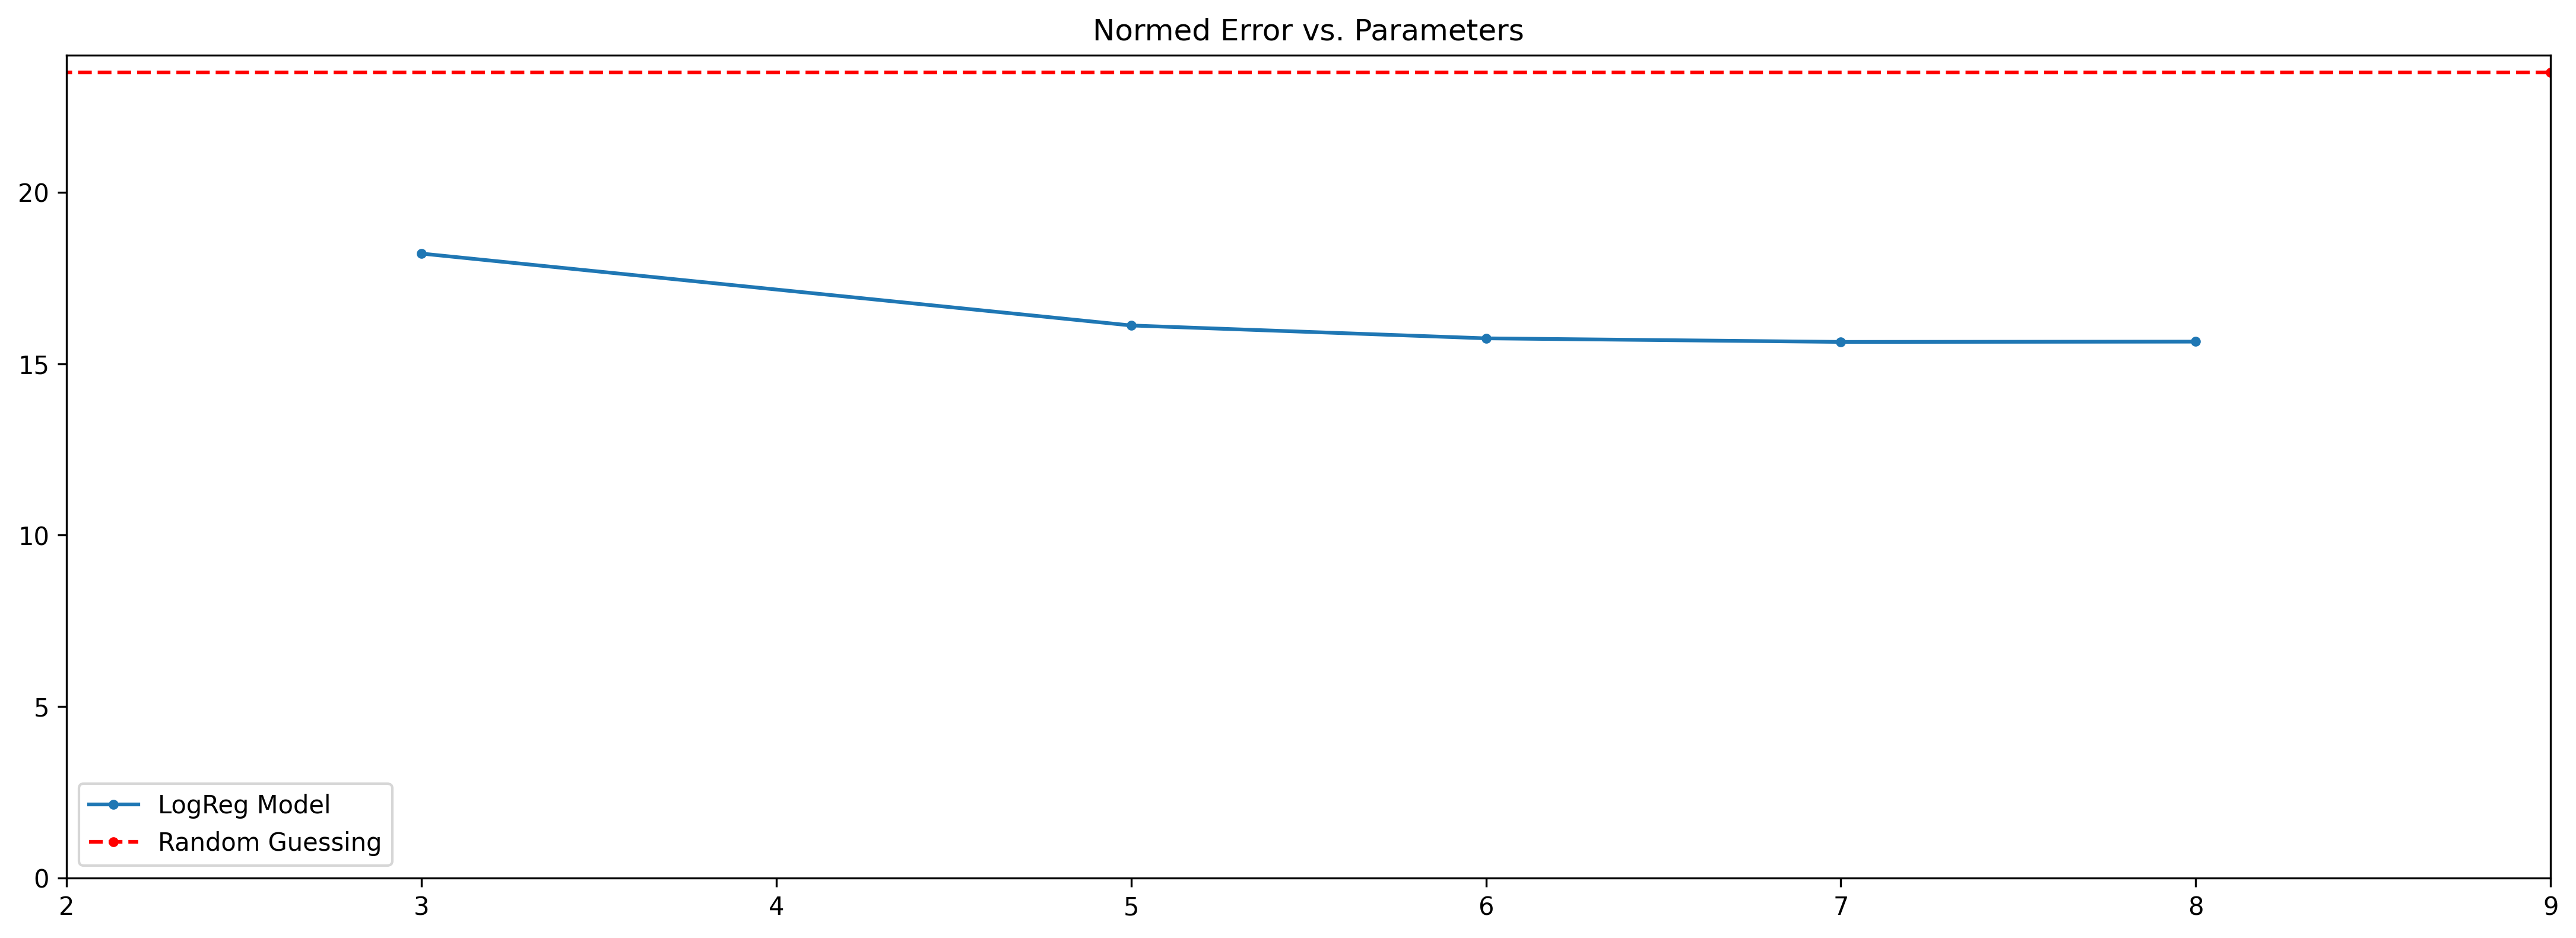

In [16]:
params = [8, 7, 6, 5, 3]
errors = [lr.normed_error for lr in [lr1, lr2, lr3, lr4, lr5]]
plt.plot(params, errors, '.-', label="LogReg Model")
plt.plot([0, 9], [23.5, 23.5], '.--r', label='Random Guessing')
plt.xlim((2, 9))
plt.ylim([0, 24])
plt.title("Normed Error vs. Parameters")
plt.legend()

plt.show()

## Statsmodel logistic regression

In [17]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model = sm.Logit(y_train, X_train_sm).fit_regularized()
probs = model.predict(X_test_sm)
la.norm(probs - y_test)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.488891352661809
            Iterations: 35
            Function evaluations: 36
            Gradient evaluations: 35


15.64252765649465

## Sklearn logistic regression

In [18]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(fit_intercept=True).fit(X_train, y_train)  # X before y
labels = model.predict(X_test)  # predicted labels of X_test

In [19]:
la.norm(y_test - labels)

np.float64(18.303005217723125)

## Visualization of grouping (PCA) and predictions (Statsmodel)

### All Params

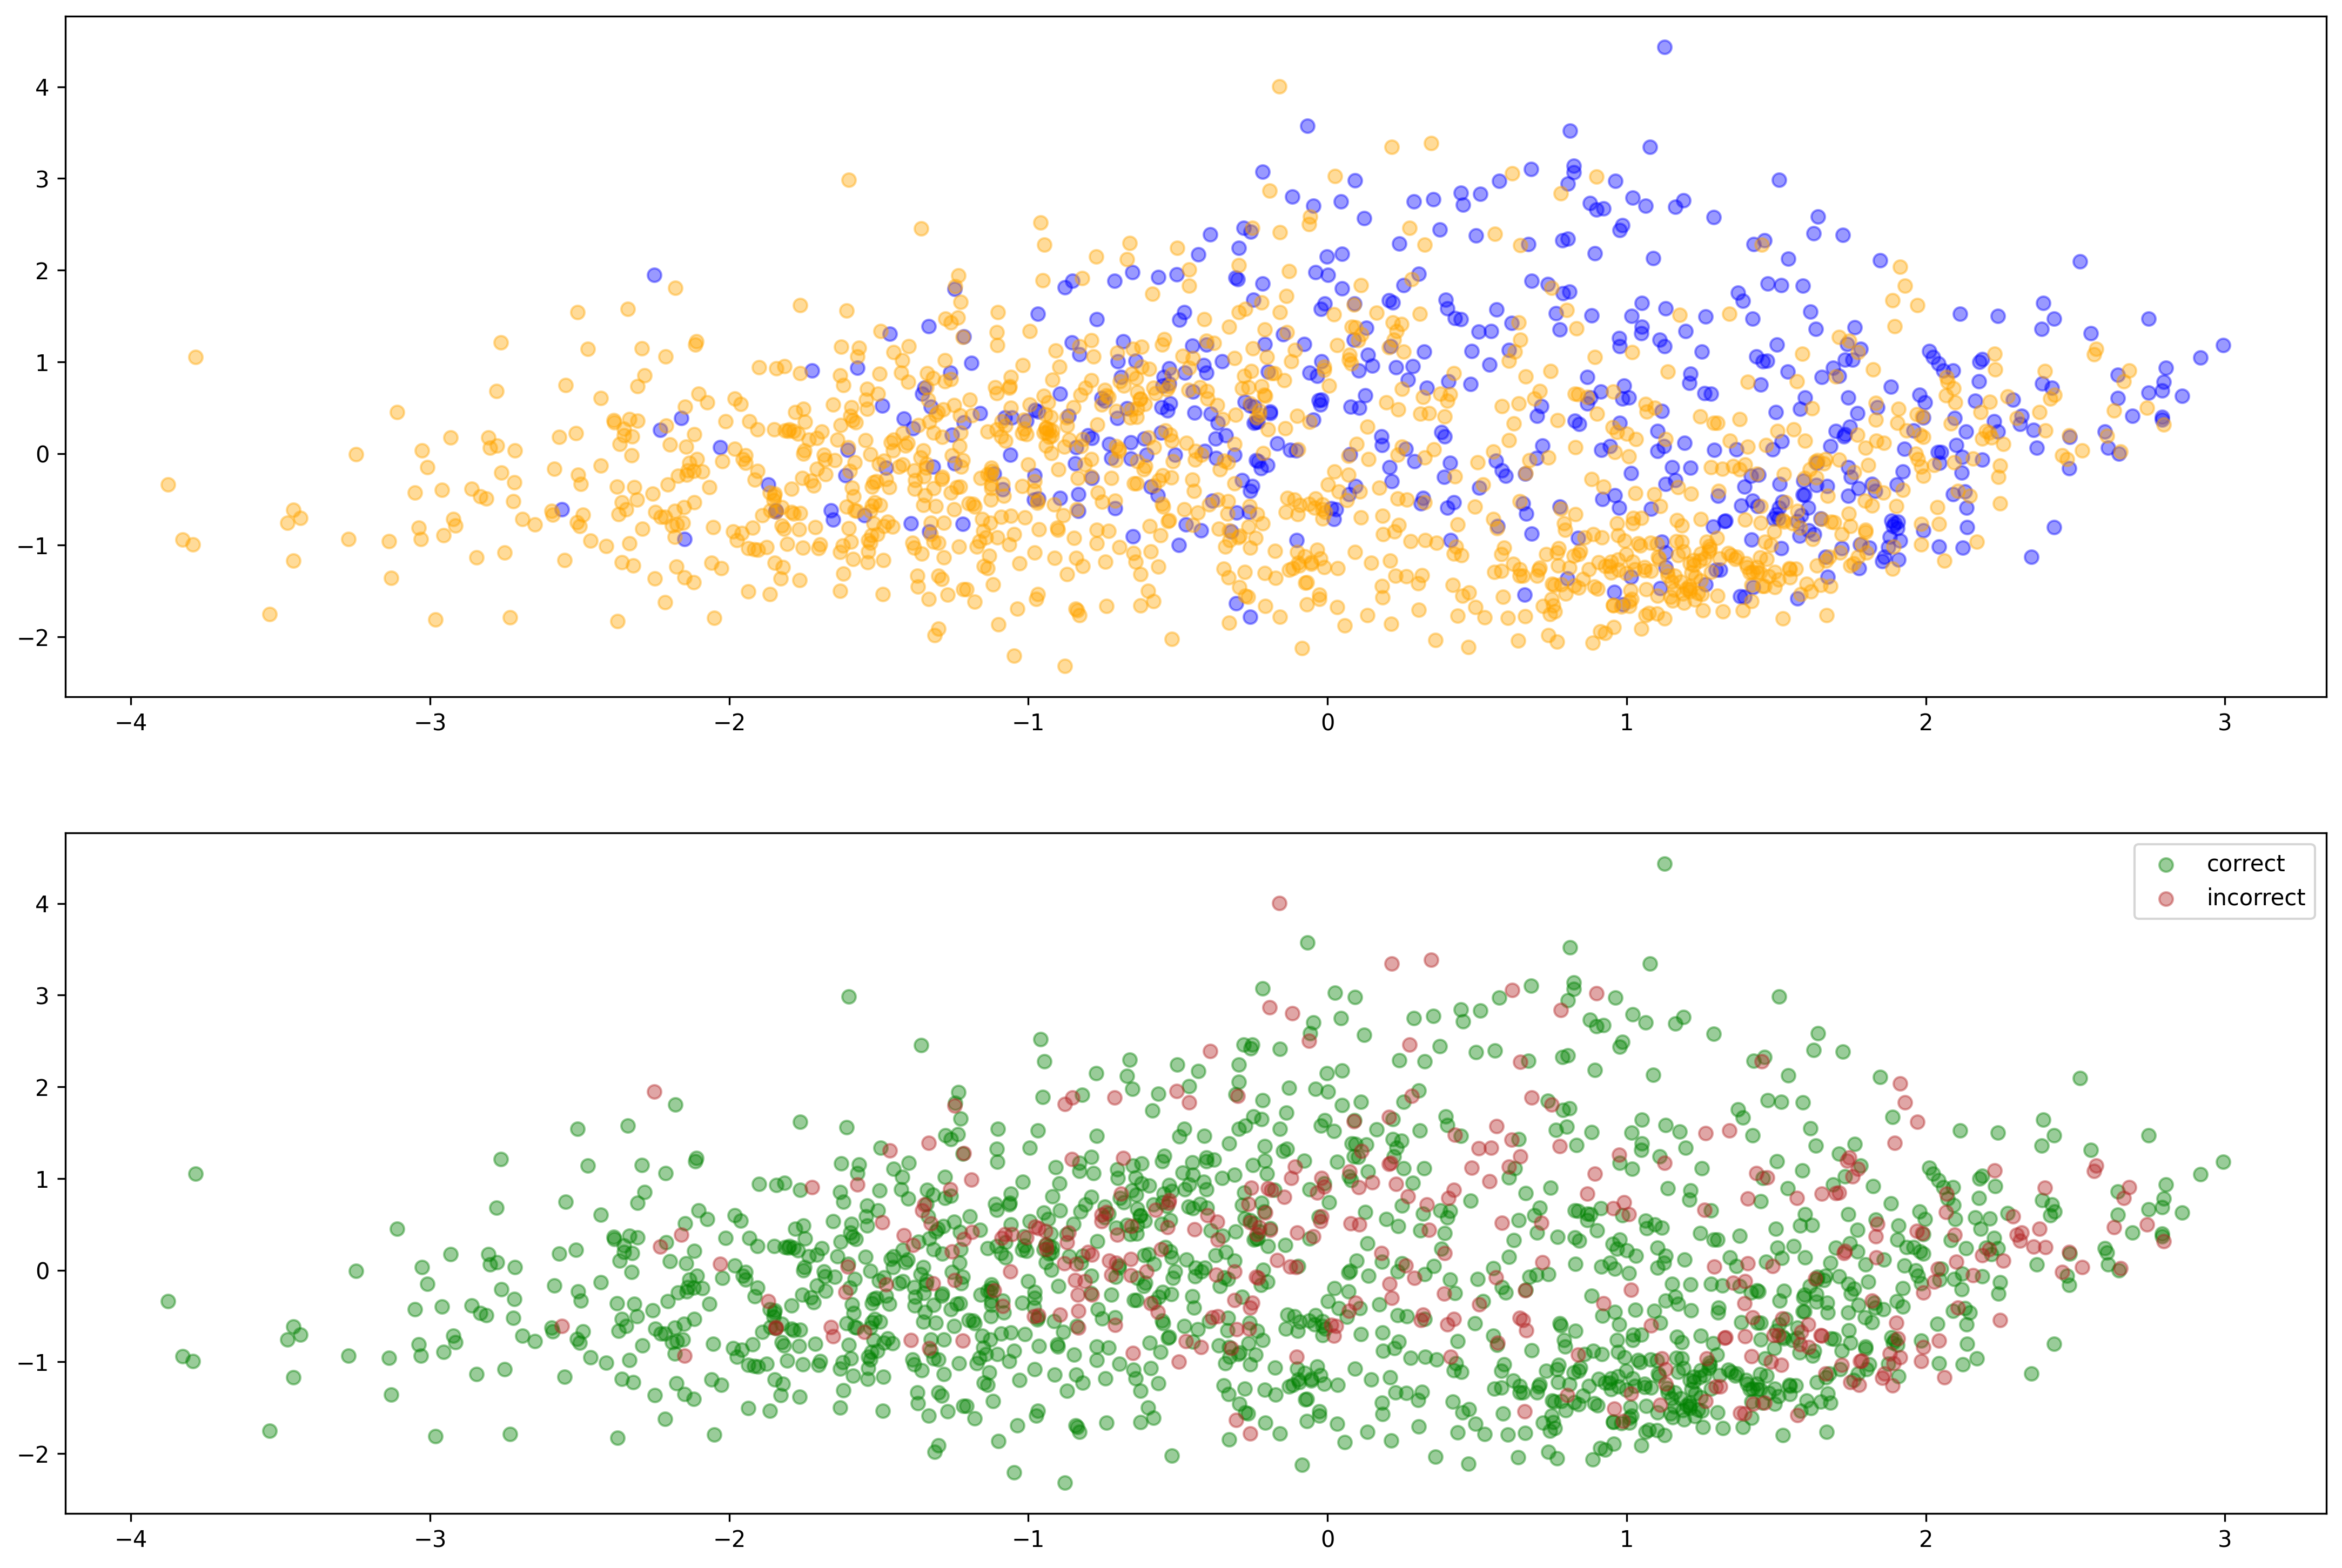

In [20]:
X = np.column_stack([np.sin(2 * np.pi * doy / 365), np.cos(2 * np.pi * doy / 365), wt_minus_one, rh, pres, wspd, dp])
X = scaler.fit_transform(X)
y = wt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=False)

fig, axes = plt.subplots(2, 1, figsize=(18, 12))


mask1 = (y_test == 1)
mask2 = (np.rint(probs) == y_test)

column_means = X_test.mean(axis=0)[None, :]
X_test = X_test - column_means

U, s, Vt = la.svd(X)
coords = X_test @ Vt.T[:, :2]

ax = axes[0]
ax.scatter(coords[mask1][:, 0], coords[mask1][:, 1], alpha = 0.4, color='b', label='rain')
ax.scatter(coords[~mask1][:, 0], coords[~mask1][:, 1], alpha = 0.4, color='orange', label='shine')

ax = axes[1]
ax.scatter(coords[mask2][:, 0], coords[mask2][:, 1], alpha = 0.4, color='green', label='correct')
ax.scatter(coords[~mask2][:, 0], coords[~mask2][:, 1], alpha = 0.4, color='firebrick', label='incorrect')

plt.legend()
plt.show()

### With LR4 model

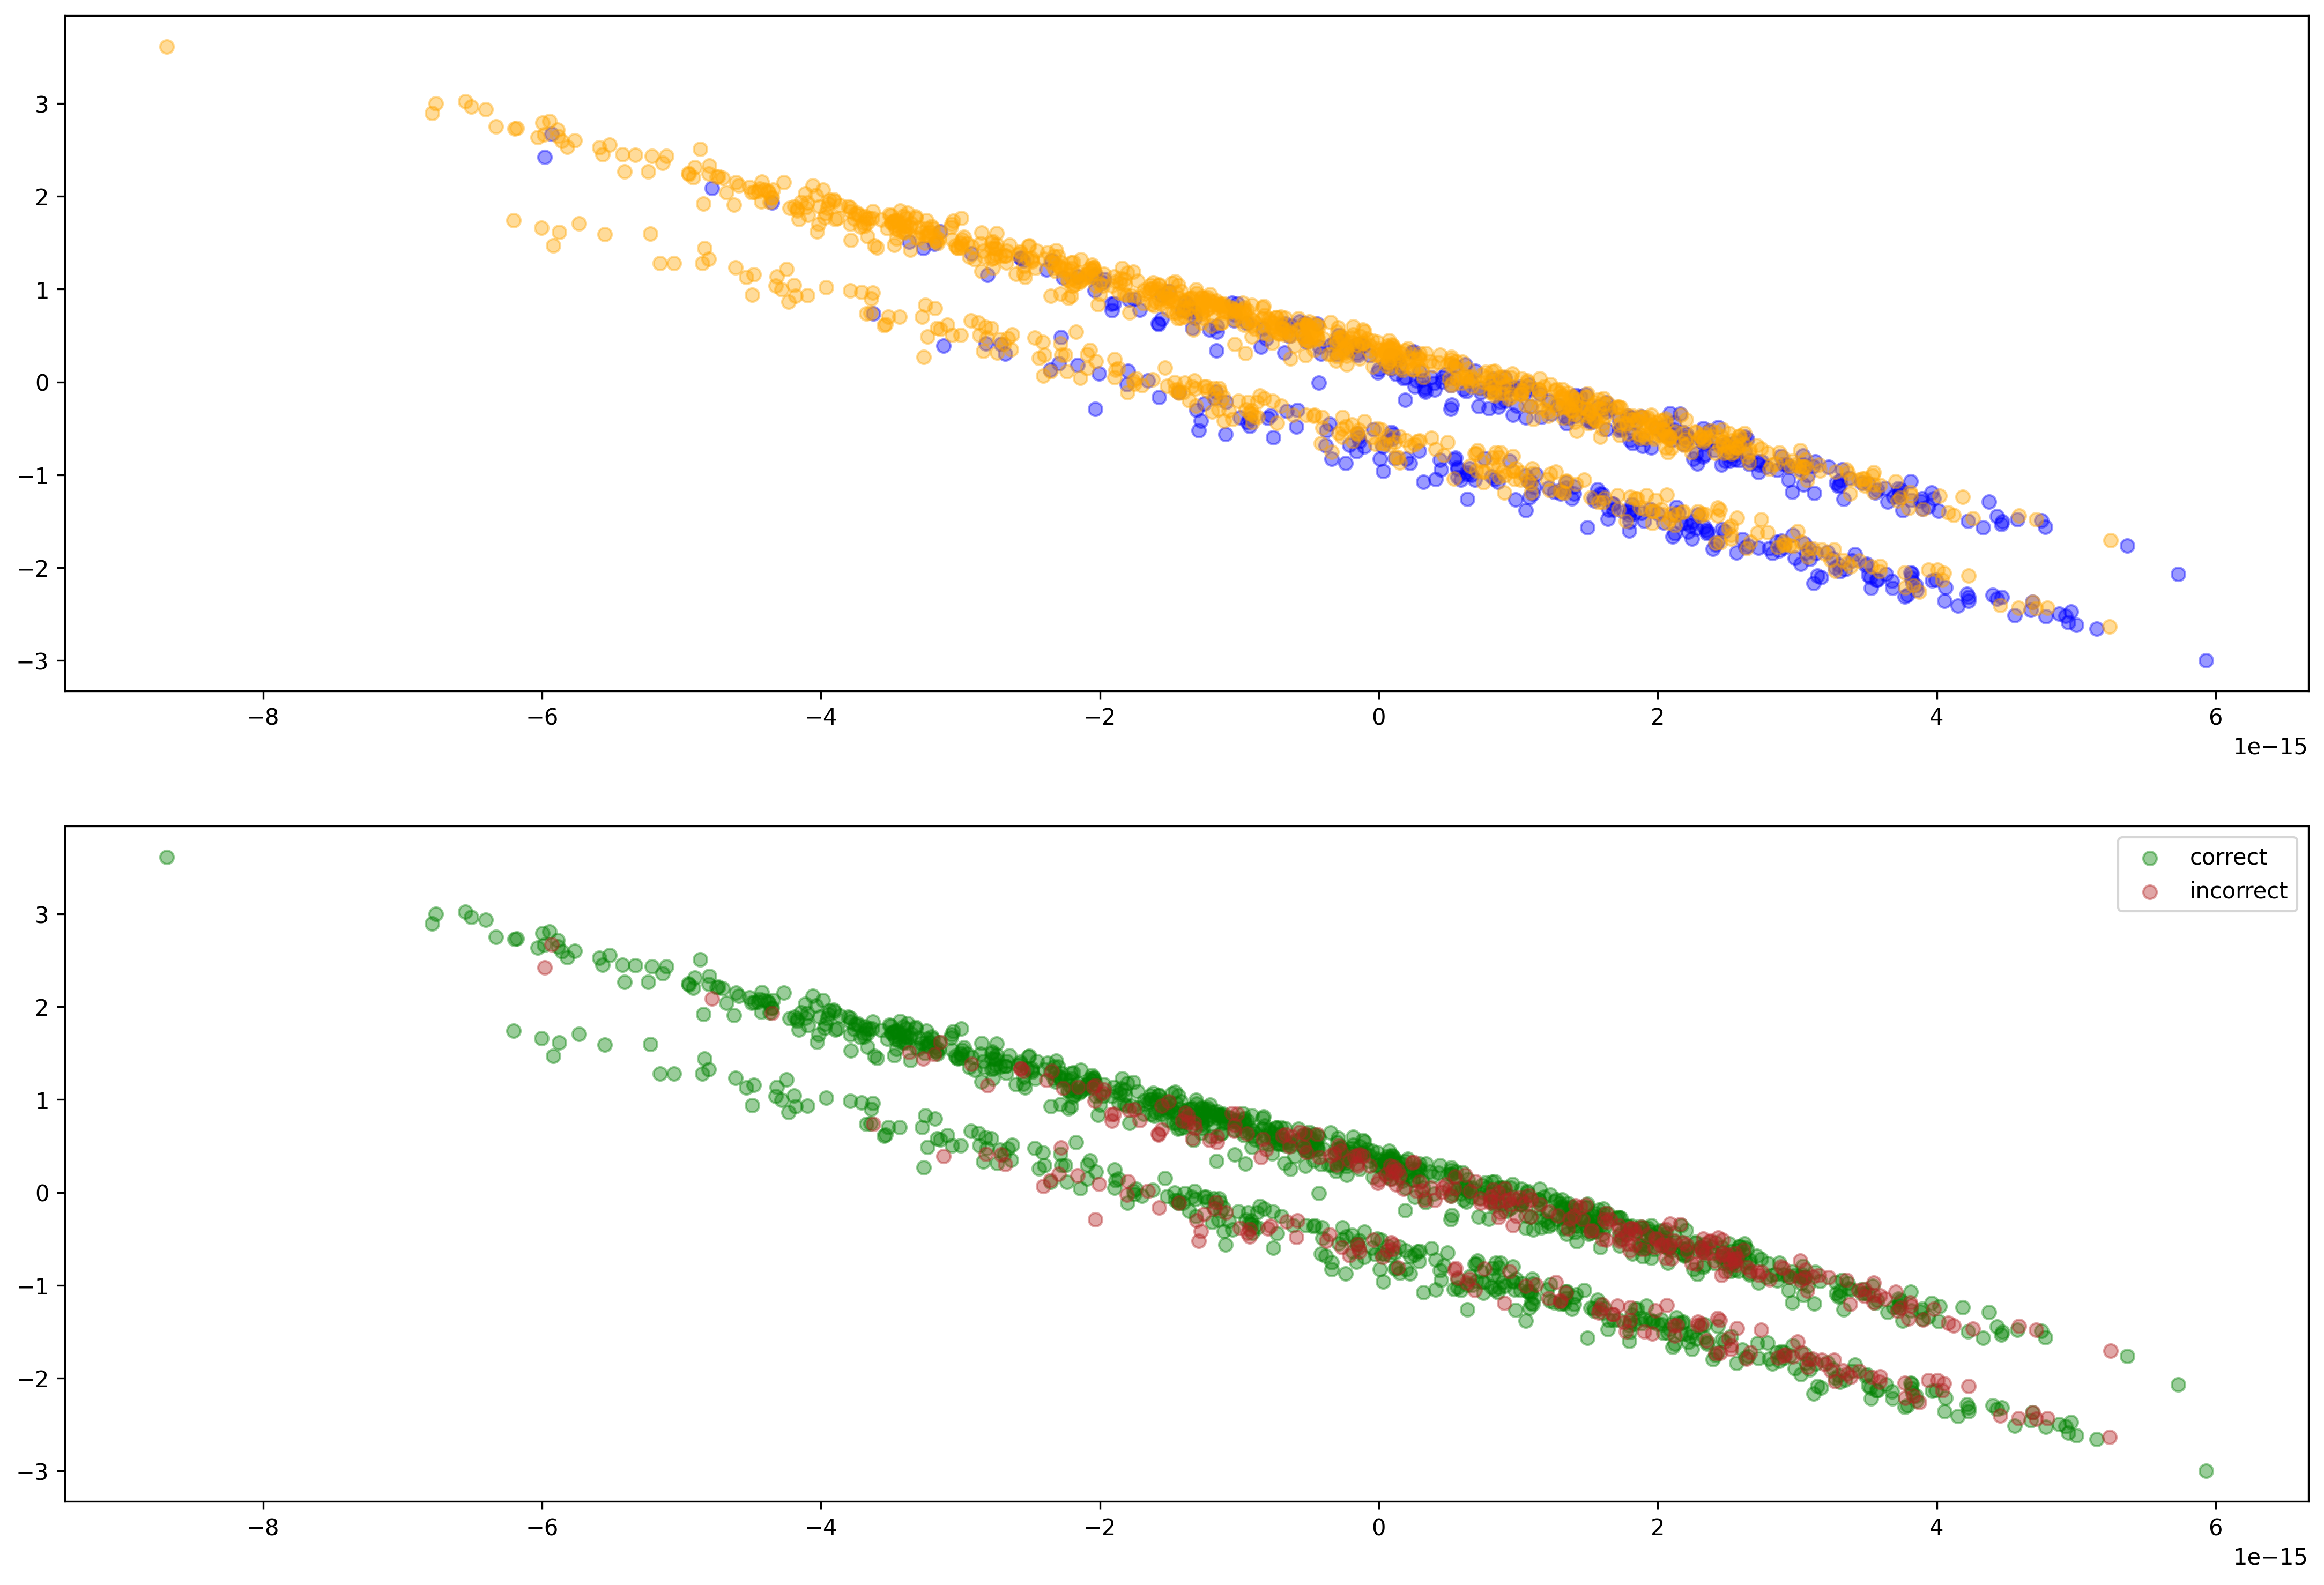

In [21]:
X = np.column_stack([wt_minus_one, rh, wspd, dp])
X = scaler.fit_transform(X4)
X = np.column_stack([np.ones(X4.shape[0]), X4])
y = wt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=False)

fig, axes = plt.subplots(2, 1, figsize=(18, 12))

mask1 = (y_test == 1)
mask2 = (np.rint(lr4.pred) == y_test)

column_means = X_test.mean(axis=0)[None, :]
X_test = X_test - column_means

U, s, Vt = la.svd(X)
coords = X_test @ Vt.T[:, :2]

ax = axes[0]
ax.scatter(coords[mask1][:, 0], coords[mask1][:, 1], alpha = 0.4, color='b', label='rain')
ax.scatter(coords[~mask1][:, 0], coords[~mask1][:, 1], alpha = 0.4, color='orange', label='shine')

ax = axes[1]
ax.scatter(coords[mask2][:, 0], coords[mask2][:, 1], alpha = 0.4, color='green', label='correct')
ax.scatter(coords[~mask2][:, 0], coords[~mask2][:, 1], alpha = 0.4, color='firebrick', label='incorrect')

plt.legend()
plt.show()

# Lake Effect